## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Merging Dataframes

1. 학생 정보 관련 파일:
   - studentInfo.csv: 학생의 인구 통계 정보, 등록 정보 등을 담고 있습니다.

2. 과정 정보 관련 파일:
   - courses.csv: 각 코스(모듈)에 대한 정보를 담고 있습니다.
   - assessments.csv: 코스 내의 평가 정보 (과제, 시험 등)를 담고 있습니다.

3. 학생 성적 관련 파일:
    - studentAssessment.csv: 학생들의 평가 점수를 담고 있습니다.
    - studentRegistration.csv: 학생의 코스 등록 정보를 담고 있습니다.
    
4. VLE 활동 관련 파일:
   - vle.csv: VLE 활동에 대한 설명 정보를 담고 있습니다.
   - studentVle.csv: 학생의 VLE(Virtual Learning Environment) 활동 데이터를 담고 있습니다.

In [3]:
assessments_df = pd.read_csv("./data/assessments.csv")
courses_df = pd.read_csv("./data/courses.csv")
studentAssessment_df = pd.read_csv("./data/studentAssessment.csv")

# vle_df = pd.read_csv("./data/vle.csv")
# studentVle_df = pd.read_csv("./data/studentVle.csv")

studentInfo_df = pd.read_csv("./data/studentInfo.csv")
studentRegistration_df = pd.read_csv("./data/studentRegistration.csv")

In [4]:
print('코스 내의 과제, 시험 정보',assessments_df.columns)
print('코스 정보',courses_df.columns)
print('학생 평가 점수',studentAssessment_df.columns)
print('학생 정보',studentInfo_df.columns)
print('학생의 등록 정보',studentRegistration_df.columns)
# print('vle 활동 정보',vle_df.columns)
# print('학생의 vle 활동 정보',studentVle_df.columns)

코스 내의 과제, 시험 정보 Index(['code_module', 'code_presentation', 'id_assessment', 'assessment_type',
       'date', 'weight'],
      dtype='object')
코스 정보 Index(['code_module', 'code_presentation', 'module_presentation_length'], dtype='object')
학생 평가 점수 Index(['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score'], dtype='object')
학생 정보 Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result'],
      dtype='object')
학생의 등록 정보 Index(['code_module', 'code_presentation', 'id_student', 'date_registration',
       'date_unregistration'],
      dtype='object')


In [5]:
# 1. 학생 평가 점수와 과제 정보 병합
merged_df = studentAssessment_df.merge(assessments_df, on='id_assessment', how='left')
# 2. 학생 정보 추가
merged_df = merged_df.merge(studentInfo_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# 3. 학생 등록 정보 추가
merged_df = merged_df.merge(studentRegistration_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# 4. 코스 정보 추가
merged_df = merged_df.merge(courses_df, on=['code_module', 'code_presentation'], how='left')

In [6]:
# 중복 행 제거
merged_df = merged_df.drop_duplicates()

In [7]:
# merged_vle_df = pd.merge(vle_df, studentVle_df, 
#                            on=['id_site', 'code_module', 'code_presentation'],
#                            how='outer')

In [8]:
# 중복 행 제거
# merged_vle_df = merged_vle_df.drop_duplicates()

---
# 데이터 전처리

### 1. 결측치 처리

### `date`

- 대부분 `assessment_type = "Exam"`에 해당
- 시험은 일반적으로 강의 종료일에 시행됨
→ `module_presentation_length`를 활용해 **강의 마지막 날짜로 채움**

In [9]:
merged_data=merged_df
merged_data['is_late'] = (merged_data['date_submitted'] > merged_data['date']).astype(int)

In [10]:
# # # 2. 컬럼 이름 정리 (공백 제거)
# # merged_data.columns = merged_data.columns.str.strip()
# # courses.columns = courses.columns.str.strip()

# # 3. 'Exam'이고 date가 NaN인 행 필터링
# is_exam_nan = (merged_data['assessment_type'] == 'Exam') & (merged_data['date'].isna())

# # 4. 강의별 강의일수 정보 가져오기 (module_presentation_length)
# module_length_map = merged_data.set_index(['code_module', 'code_presentation'])['module_presentation_length']

# # 5. 결측 date 값 채우기
# def fill_exam_date(row):
#     if row['assessment_type'] == 'Exam' and pd.isna(row['date']):
#         return module_length_map.get((row['code_module'], row['code_presentation']), row['date'])
#     return row['date']

# merged_data['date'] = merged_data.apply(fill_exam_date, axis=1)


### 🔹 결측치 제거

### `score`

- 총 173건 결측
    - `Withdrawn`(이탈자): 72개
    - `Pass`, `Fail`, `Distinction`(수료자): 101개
- 과제를 제출했는데도 점수가 없는 경우로 추정… 수가 적으므로 **삭제 처리**

### `date_registration`

- 수강 등록일이 없는 7건 → **삭제**

In [11]:
# score가 NaN인 사람들 중에 이탈하지 않은 사람
score_nan_but_not_withdrawn = merged_data[merged_data['score'].isna() & (merged_data['final_result'] != 'Withdrawn')]

# score가 NaN인 사람들 중에 이탈한 사람
score_nan_and_withdrawn = merged_data[merged_data['score'].isna() & (merged_data['final_result'] == 'Withdrawn')]

# 결과 확인
# print(score_nan_but_not_withdrawn[['id_student', 'id_assessment', 'final_result']])
print(f"수료했는데도 score가 결측인 사람 수: {len(score_nan_but_not_withdrawn)}명")

# print(score_nan_and_withdrawn[['id_student', 'id_assessment', 'final_result']])
print(f"이탈했고 score가 결측인 사람 수: {len(score_nan_and_withdrawn)}명")


# Score 결측치 데이터(173개) + date_registration 결측치 데이터(7개) 데이터 제거

df_cleaned = merged_data.dropna(subset=['score','date_registration'])

df=df_cleaned


수료했는데도 score가 결측인 사람 수: 101명
이탈했고 score가 결측인 사람 수: 72명


### `imd_band`

- 총 7697건 결측
- 전체 28,785명 중 약 **971명**의 `imd_band`(지역 기반 사회경제 수준 지표)가 없음

- imd_band에 데이터를 넣는코드

In [12]:
# 'imd_band' 컬럼의 NaN 값을 'Unknown'으로 채우기
# unknown 대신 다른 문자열로 채울 수 있음
# 숫자로도 넣을 수 있음.
df.loc[:, 'imd_band'] = df['imd_band'].fillna('Unknown')

- 'imd_band' 컬럼에서 결측치가 있는 행을 삭제

In [13]:
df = df.dropna(subset=['imd_band','date'])

In [14]:
df.isnull().sum()

id_assessment                      0
id_student                         0
date_submitted                     0
is_banked                          0
score                              0
code_module                        0
code_presentation                  0
assessment_type                    0
date                               0
weight                             0
gender                             0
region                             0
highest_education                  0
imd_band                           0
age_band                           0
num_of_prev_attempts               0
studied_credits                    0
disability                         0
final_result                       0
date_registration                  0
date_unregistration           157891
module_presentation_length         0
is_late                            0
dtype: int64

In [15]:
print(df['imd_band'].isna().sum())  # NaN 개수 확인
print(df['disability'].unique())  # imd_band 컬럼의 고유값 확인

0
['N' 'Y']


In [16]:
gender_to_income = {
    'M': 0,    
    'F': 1
}

disabil_to_income = {
    'N': 0,    
    'Y': 1
}


imd_band_to_income = {
    '90-100%': 9,  
    '80-90%': 8,  
    '70-80%': 7, 
    '60-70%': 6, 
    '50-60%': 5, 
    '40-50%': 4, 
    '30-40%': 3,  
    '20-30%': 2,    
    '10-20': 1, 
    '0-10%': 0,    
    'Unknown': 0     
}
df['gender'] = df['gender'].map(gender_to_income)
df['disability'] = df['disability'].map(disabil_to_income)
df['imd_band'] = df['imd_band'].map(imd_band_to_income)

/tmp/ipykernel_88614/4219717012.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = df['gender'].map(gender_to_income)
/tmp/ipykernel_88614/4219717012.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disability'] = df['disability'].map(disabil_to_income)
/tmp/ipykernel_88614/4219717012.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

### `date_unregistration`

- 결측치 160,857건
- 해당 컬럼은 **"언제 수강을 중도 이탈했는가"**를 의미
→ **결측 = 중도 이탈하지 않은 수료자**
→ 즉, 의미 있는 결측이므로 **삭제하지 않음** → 인코딩 과정에서 결측치를 처리 한다!!!

---

- date_unregistration 이상치 제거
- Fail값이 나올 수 없기 때문에 이상치 처리해야함!!!!!!!!!!!!!!!!!!!!
- 조건 -> final_result 값 안에 Fail 일 때 date_unregistration이 0보다 크거나 같을 때

### `final_result 이상치 처리 코드`

In [17]:
df[(df['final_result'] == 'Fail') & (df['date_unregistration'] >= 0)]

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,...,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length,is_late
15046,14996,554243,18,0,61.0,BBB,2013J,TMA,19.0,5.0,...,6,0-35,0,60,0,Fail,-35.0,166.0,268,0
16810,14997,554243,47,0,81.0,BBB,2013J,TMA,47.0,18.0,...,6,0-35,0,60,0,Fail,-35.0,166.0,268,0
22931,15003,554243,56,0,100.0,BBB,2013J,CMA,54.0,1.0,...,6,0-35,0,60,0,Fail,-35.0,166.0,268,1
24489,15004,554243,102,0,80.0,BBB,2013J,CMA,96.0,1.0,...,6,0-35,0,60,0,Fail,-35.0,166.0,268,1
26445,15005,554243,133,0,80.0,BBB,2013J,CMA,131.0,1.0,...,6,0-35,0,60,0,Fail,-35.0,166.0,268,1
26904,15006,554243,168,0,100.0,BBB,2013J,CMA,166.0,1.0,...,6,0-35,0,60,0,Fail,-35.0,166.0,268,1
76597,25348,403052,26,0,32.0,DDD,2013J,TMA,25.0,10.0,...,2,0-35,0,150,0,Fail,-22.0,0.0,261,1
77242,25349,403052,53,0,39.0,DDD,2013J,TMA,53.0,12.5,...,2,0-35,0,150,0,Fail,-22.0,0.0,261,0
78690,25350,403052,89,0,68.0,DDD,2013J,TMA,88.0,17.5,...,2,0-35,0,150,0,Fail,-22.0,0.0,261,1
80366,25351,403052,128,0,25.0,DDD,2013J,TMA,123.0,20.0,...,2,0-35,0,150,0,Fail,-22.0,0.0,261,1


In [18]:
df = df.drop(df[(df['final_result'] == 'Fail') & (df['date_unregistration'] >= 0)].index)

In [19]:
merged_data=df

### 2. 이상치 처리 및 시각화
   - 수치형 변수의 이상치 확인 및 처리(예: score, studied_credits의 극단값 혹은 0 값 등)

### 3. 데이터 타입 변환
   - 날짜 관련 변수를 datetime 형식으로 변환
   - 범주형 변수를 category 타입으로 변환

### 4. 특성 엔지니어링

#### 학생의 성적 관련 특성
  - 각 학생의 평균 점수, 최고 점수, 최저 점수, 점수의 표준편차
    - 각 학생당 코스별 성적 편차 필요할까?
  - 점수 추세 (상승 또는 하락)
  - 과제 난이도에 따른 가중 점수 -> 난이도 기준을 뭘로 잡아야하나?
 
##### my_average_score, my_max_score, my_min_score, my_score_std, my_score_trend, assesment_weight, weighted_score

- my_avg_score : 개인 학업 성취도 수준 파악
- my_max/min_score/my_score_std : 특정 과목 강점/약점 식별 및 극단적 편차 분석
- my_score_trend	: 학습 효과성 평가 (지속적 상승=효율적 학습법, 하락=개입 필요)
- weighted_score :	난이도 대비 성취도 → "B과제는 고난이도지만 고가중점수 → Distinct 학생" 

In [20]:
# 학생의 평균, 최고, 최저 점수 및 표준편차 계산
student_scores = merged_data.groupby('id_student')['score'].agg(['mean', 'max', 'min', 'std']).reset_index()

student_scores.columns = ['id_student', 'my_average_score', 'my_max_score', 'my_min_score', 'my_score_std']

# # 학생의 코스별 성적 표준편차 계산
# score_std_by_module = merged_data.groupby(['id_student', 'code_module'])['score'].std().reset_index()
# score_std_by_module = score_std_by_module.pivot(index='id_student', columns='code_module', values='score').reset_index()
# score_std_by_module.columns = ['id_student'] + [f'score_std_{col}' for col in score_std_by_module.columns if col != 'id_student']

# 점수 추세 분석
merged_data_sorted = merged_data.sort_values(by=['id_student', 'date_submitted'])
merged_data_sorted['score_diff'] = merged_data_sorted.groupby('id_student')['score'].diff()

def determine_trend(diff):
    if diff > 0:
        return 0
    else:
        return 1
    
merged_data_sorted['score_trend'] = merged_data_sorted['score_diff'].apply(determine_trend)
student_trends = merged_data_sorted.groupby('id_student')['score_trend'].apply(lambda x: x.value_counts().idxmax()).reset_index()
student_trends.columns = ['id_student', 'my_score_trend']

# 모든 특성을 하나의 데이터프레임으로 병합
student_features = pd.merge(student_scores, student_trends, on='id_student')

# 원본 데이터와 새로운 특성을 병합
merged_data = pd.merge(merged_data, student_features, on='id_student')

# 과제 난이도 가중치를 적용한 점수 (평균 기반)

# weight 계산 (평균 점수가 낮을수록 가중치가 높아짐)
avg = merged_data.groupby('id_assessment')['score'].mean()
max_avg = avg.max()
weight = (max_avg - avg) / (max_avg - avg).sum()

# weight를 데이터프레임으로 변환
weight_df = weight.reset_index()
weight_df.columns = ['id_assessment', 'assessment_weight']
merged_data = pd.merge(merged_data, weight_df, on='id_assessment', how='left')
# 가중 점수 계산
merged_data['weighted_score'] = merged_data['score'] * merged_data['assessment_weight']

#### 코스 관련 특성
  - 코스별 평균 점수, 최고 점수, 최저 점수, 점수의 표준편차 -> 최저 점수 다 0임, 최고점이 필요한가?, 중간값이 필요한가?
  - 코스별 과제 개수

##### 'course_avg_score', 'course_std_score', 'assignment_count'

- course_avg_score, course_std_score :	평가 방식 적정성 → 편차↑=과도한 변별력 / 강좌 난이도 레벨링
- assignment_count :	과제량-성적 상관관계 분석 → 최적 과제량 도출

In [21]:
# 과목별 통계 계산
subject_stats = merged_data.groupby(['code_presentation', 'code_module']).agg({
    'score': ['mean', 'max', 'std']
})
subject_stats.columns = ['course_avg_score', 'course_max_score', 'course_std_score']

# 과목 통계 데이터 병합
merged_data = merged_data.merge(
    subject_stats.reset_index(),
    on=['code_presentation', 'code_module'],
    how='left'
)
merged_data['assignment_count'] = merged_data.groupby(['code_presentation', 'code_module'])['id_assessment'].transform('nunique')


# # 과목별 난이도 가중치를 적용한 점수 (표준편차 기반)
# difficulty = subject_stats['course_std_score']
# weights = (difficulty / difficulty.sum()) * 10
# merged_data = merged_data.merge(
#     weights.rename('course_weight'), 
#     left_on='code_module', 
#     right_index=True
# )
# merged_data['weighted_score'] = merged_data['score'] * merged_data['course_weight']

In [22]:
merged_data[merged_data['code_module']=='AAA']

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,...,my_max_score,my_min_score,my_score_std,my_score_trend,assessment_weight,weighted_score,course_avg_score,course_max_score,course_std_score,assignment_count
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,...,85.0,78.0,3.082207,1,0.007034,0.548627,69.431637,98.0,12.639410,5
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,...,70.0,60.0,4.335897,1,0.007034,0.492358,69.431637,98.0,12.639410,5
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,...,88.0,71.0,6.892024,1,0.007034,0.506425,69.431637,98.0,12.639410,5
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,...,75.0,30.0,20.513410,1,0.007034,0.485324,69.431637,98.0,12.639410,5
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,...,79.0,50.0,10.977249,1,0.007034,0.555661,69.431637,98.0,12.639410,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,1762,2654628,216,0,74.0,AAA,2014J,TMA,215.0,30.0,...,74.0,69.0,2.509980,1,0.007358,0.544481,68.598680,95.0,13.291518,5
3142,1762,2677624,215,0,79.0,AAA,2014J,TMA,215.0,30.0,...,79.0,58.0,9.181503,1,0.007358,0.581270,68.598680,95.0,13.291518,5
3143,1762,2680312,220,0,85.0,AAA,2014J,TMA,215.0,30.0,...,86.0,73.0,6.220932,1,0.007358,0.625417,68.598680,95.0,13.291518,5
3144,1762,2688166,214,0,46.0,AAA,2014J,TMA,215.0,30.0,...,69.0,46.0,11.030261,1,0.007358,0.338461,68.598680,95.0,13.291518,5


#### 행동 패턴 특성
- 전체 학생 기준
  - 코스별 과제 제출률 => 제출률 100프로
  - 코스별 지각 제출 비율
  - 과제별 제출 시간의 평균, 중앙값, 표준편차

- 한명 학생 기준
  - 과제 제출률 => 제출률 100프로
  - 지각 제출 비율
  - 이탈 학생의 이탈 단계 할당

##### 'course_late_rate', 'my_late_rate', 'days_early_submission_avg', 'days_early_submissione_max', 'days_early_submission_min','days_early_submission_std','days_early_submission', 'is_late', 'unregistration_stage'

- my_late_rate	: 습관적 지각 여부 → 학습태도 평가 지표
- days_early_submission_*	: 과제의 난의도 판별 → 평균 7일 이상 = 쉬운 과제인가, 평균 0일 이하 = 어려운 과제인가, 표준편차가 크다 = 학생의 역량
- course_late_rate : 코스의 난의도 판별 -> 필요없을까?
- unregistration_stage : 첫 번째 과제 이후 이탈-> 수업의 어려움보다는 외부적인 이유일 가능성이 높음 / 중간쯤 과제 제출 후 이탈->학업에서의 고충이나 과제의 난이도 등이 영향이 있을 수 있음

In [23]:
# 모든 학생 기준
# 1. 코스별 평균 제출률 계산
# 1-1. 학생별 코스 내 제출률 계산
# student_course_submission = merged_data.groupby(['code_module', 'id_student']).agg(
#     student_submissions=('id_assessment', 'count'),
#     course_assessments=('id_assessment', 'nunique')
# ).astype({'student_submissions': int, 'course_assessments': int}).reset_index()

# # 1-2. 학생별 제출률 계산
# student_course_submission['student_submission_rate'] = (
#     student_course_submission['student_submissions']
#     / student_course_submission['course_assessments']
# )
# course_stats = student_course_submission.groupby('code_module')['student_submission_rate'].mean().reset_index()
# course_stats.columns = ['code_module', 'course_avg_submission_rate']
# student_course_submission[student_course_submission['student_submission_rate'] != 1]

# 2. 코스별 지각 제출 비율
# 3. 과제별 제출시간 평균, 중간, 표준편차

# 개인기준
# # 1. 학생별 과제 제출률
# student_stats = merged_data.groupby('id_student').agg(
#     student_submissions=('id_assessment', 'count'),
#     total_assignments=('id_assessment', 'nunique')
# ).reset_index()
# student_stats['student_submission_rate'] = student_stats['student_submissions'] / student_stats['total_assignments']
# student_stats[student_stats['student_submission_rate'] != 1]

# 2. 학생별 지각 제출 비율

In [24]:
# 코스별 지각 제출 비율
# merged_data['is_late'] = (merged_data['date_submitted'] > merged_data['date']).astype(int)
merged_data['course_late_rate'] = merged_data.groupby(['code_presentation', 'code_module'])['is_late'].transform('mean')

# 과제별 데드라인 전 제출 시간 평균, 중간, 표준편차
merged_data['days_early_submission'] = merged_data['date'] - merged_data['date_submitted']  # 컬럼명 변경 권장
assessment_stats = merged_data.groupby('id_assessment')['days_early_submission'].agg([
    ('days_early_submission_avg', 'mean'),
    ('days_early_submission_max', 'max'),
    ('days_early_submission_min', 'min'),
    ('days_early_submission_std', 'std')
]).reset_index()
merged_data = merged_data.merge(assessment_stats, on='id_assessment')

# 학생별 지각 제출 비율
merged_data['my_late_rate'] = merged_data.groupby('id_student')['is_late'].transform('mean')

In [25]:
dropped_out_students = merged_data[merged_data['date_unregistration'].notnull()]

# 이탈한 학생이 제출한 과제 수 계산 (학생, 과목별로 그룹화)
submitted_assignments = dropped_out_students.groupby(['id_student', 'code_presentation', 'code_module'])['id_assessment'].count().reset_index()
submitted_assignments.rename(columns={'id_assessment': 'submitted_count'}, inplace=True)
merged_data = merged_data.merge(submitted_assignments, on=['id_student', 'code_presentation', 'code_module'], how='left')

# 이탈 학생의 과제 제출률 계산 (이탈 학생의 과목당 제출 과제 수 / 과목당 전체 과제 수)
merged_data['submitted_proportion'] = merged_data['submitted_count'] / merged_data['assignment_count']
merged_data['submitted_proportion'] = merged_data['submitted_proportion'].fillna(0)

# 이탈 학생의 이탈 단계 할당
def assign_stage_based_on_proportion(row):
    if pd.isna(row['date_unregistration']):
        return 0
    elif row['submitted_proportion'] < 0.33:  # Less than 33% of total assignments
        return 1
    elif row['submitted_proportion'] < 0.66:  # Between 33% and 66%
        return 2
    else:                                     # More than 66%
        return 3

merged_data['unregistration_stage'] = merged_data.apply(assign_stage_based_on_proportion, axis=1)

In [26]:
merged_data.isnull().sum()

id_assessment                      0
id_student                         0
date_submitted                     0
is_banked                          0
score                              0
code_module                        0
code_presentation                  0
assessment_type                    0
date                               0
weight                             0
gender                             0
region                             0
highest_education                  0
imd_band                           0
age_band                           0
num_of_prev_attempts               0
studied_credits                    0
disability                         0
final_result                       0
date_registration                  0
date_unregistration           157891
module_presentation_length         0
is_late                            0
my_average_score                   0
my_max_score                       0
my_min_score                       0
my_score_std                    1953
m

In [27]:
merged_data.loc[merged_data['unregistration_stage'].notnull(), 
                ['id_student','code_presentation', 'code_module','unregistration_stage']]


,id_student,code_presentation,code_module,unregistration_stage
0,11391,2013J,AAA,0
1,28400,2013J,AAA,0
2,31604,2013J,AAA,0
3,32885,2013J,AAA,0
4,38053,2013J,AAA,0
...,...,...,...,...
170852,527538,2014J,GGG,0
170853,534672,2014J,GGG,0
170854,546286,2014J,GGG,0
170855,546724,2014J,GGG,0


#### 아래부터는 EDA 아이디어가 정해진 후 진행

### 6. 범주형 변수 인코딩
   - 필요에 따라 원-핫 인코딩 또는 라벨 인코딩 적용

In [28]:
df=merged_data

In [29]:

df.loc[:, 'final_result'] = df['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)

# df.loc[:, 'date_unregistration'] = df['date_unregistration'].apply(lambda x: 1 if pd.notna(x) else 0)

# -> 조건을 주지 않고 원 핫 인코딩을 실행함
encode_cols = ['code_module', 'code_presentation', 'assessment_type']
df_encoded = pd.get_dummies(df[encode_cols], drop_first=False)

# 'age_band' 값을 매핑하여 숫자로 변환
df['age_band'] = df['age_band'].astype(str)
age_band_map = {'0-35': 0, '35-55': 1, '55<=': 2}
df['age_band'] = df['age_band'].map(age_band_map)


# 원핫인코딩 제외한 나머지 컬럼 가져오기
df_other = df.drop(columns=encode_cols)

# 변환된 데이터프레임 합치기
df = pd.concat([df_other, df_encoded], axis=1)

# 결과 확인
df['final_result'].value_counts()
df['final_result']=df['final_result'].astype(int)


In [30]:
education_to_income = {
    'Post Graduate Qualification': 6926,  
    'HE Qualification': 4699,      
    'A Level or Equivalent': 3630,     
    'Lower Than A Level': 3576,        
    'No Formal quals': 3000     
}

df['highest_education'] = df['highest_education'].map(education_to_income)

df = df.dropna(subset='my_score_std')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168904 entries, 0 to 170856
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id_assessment               168904 non-null  int64  
 1   id_student                  168904 non-null  int64  
 2   date_submitted              168904 non-null  int64  
 3   is_banked                   168904 non-null  int64  
 4   score                       168904 non-null  float64
 5   date                        168904 non-null  float64
 6   weight                      168904 non-null  float64
 7   gender                      168904 non-null  int64  
 8   region                      168904 non-null  object 
 9   highest_education           168904 non-null  int64  
 10  imd_band                    168904 non-null  int64  
 11  age_band                    168904 non-null  int64  
 12  num_of_prev_attempts        168904 non-null  int64  
 13  studied_credits    

### 5. 불필요한 특성 제거
   - 분석에 불필요하거나 중복되는 정보를 가진 열 제거

In [31]:
df = df.drop(columns=['is_banked','submitted_count','assignment_count','date_unregistration','my_min_score','my_max_score', 
                      'id_assessment', 'id_student','score','is_late','days_early_submission_max','days_early_submission_min',
                      'days_early_submission_std','days_early_submission_avg','date','weight',
                          'date_submitted', 'region', 'unregistration_stage', 'submitted_proportion'],axis=1)


### 7. 스케일링(-> 모델링 시점에 할 지 안할지 정해도 될듯)
   - 수치형 변수에 대해 표준화 또는 정규화 적용

---
# **Exploratory Data Analysis**

## **특성간의 상관관계 확인**
- 특성간의 상관관계 확인 후 상관계수가 높은 변수끼리 그룹화하여 그룹별 성과와의 상관관계 분석

In [32]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
Index: 168904 entries, 0 to 170856
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gender                      168904 non-null  int64  
 1   highest_education           168904 non-null  int64  
 2   imd_band                    168904 non-null  int64  
 3   age_band                    168904 non-null  int64  
 4   num_of_prev_attempts        168904 non-null  int64  
 5   studied_credits             168904 non-null  int64  
 6   disability                  168904 non-null  int64  
 7   final_result                168904 non-null  int64  
 8   date_registration           168904 non-null  float64
 9   module_presentation_length  168904 non-null  int64  
 10  my_average_score            168904 non-null  float64
 11  my_score_std                168904 non-null  float64
 12  my_score_trend              168904 non-null  int64  
 13  assessment_weight  

Index(['gender', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result',
       'date_registration', 'module_presentation_length', 'my_average_score',
       'my_score_std', 'my_score_trend', 'assessment_weight', 'weighted_score',
       'course_avg_score', 'course_max_score', 'course_std_score',
       'course_late_rate', 'days_early_submission', 'my_late_rate',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J',
       'assessment_type_CMA', 'assessment_type_Exam', 'assessment_type_TMA'],
      dtype='object')

In [33]:
df.to_csv('merged_data_final.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168904 entries, 0 to 170856
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gender                      168904 non-null  int64  
 1   highest_education           168904 non-null  int64  
 2   imd_band                    168904 non-null  int64  
 3   age_band                    168904 non-null  int64  
 4   num_of_prev_attempts        168904 non-null  int64  
 5   studied_credits             168904 non-null  int64  
 6   disability                  168904 non-null  int64  
 7   final_result                168904 non-null  int64  
 8   date_registration           168904 non-null  float64
 9   module_presentation_length  168904 non-null  int64  
 10  my_average_score            168904 non-null  float64
 11  my_score_std                168904 non-null  float64
 12  my_score_trend              168904 non-null  int64  
 13  assessment_weight  

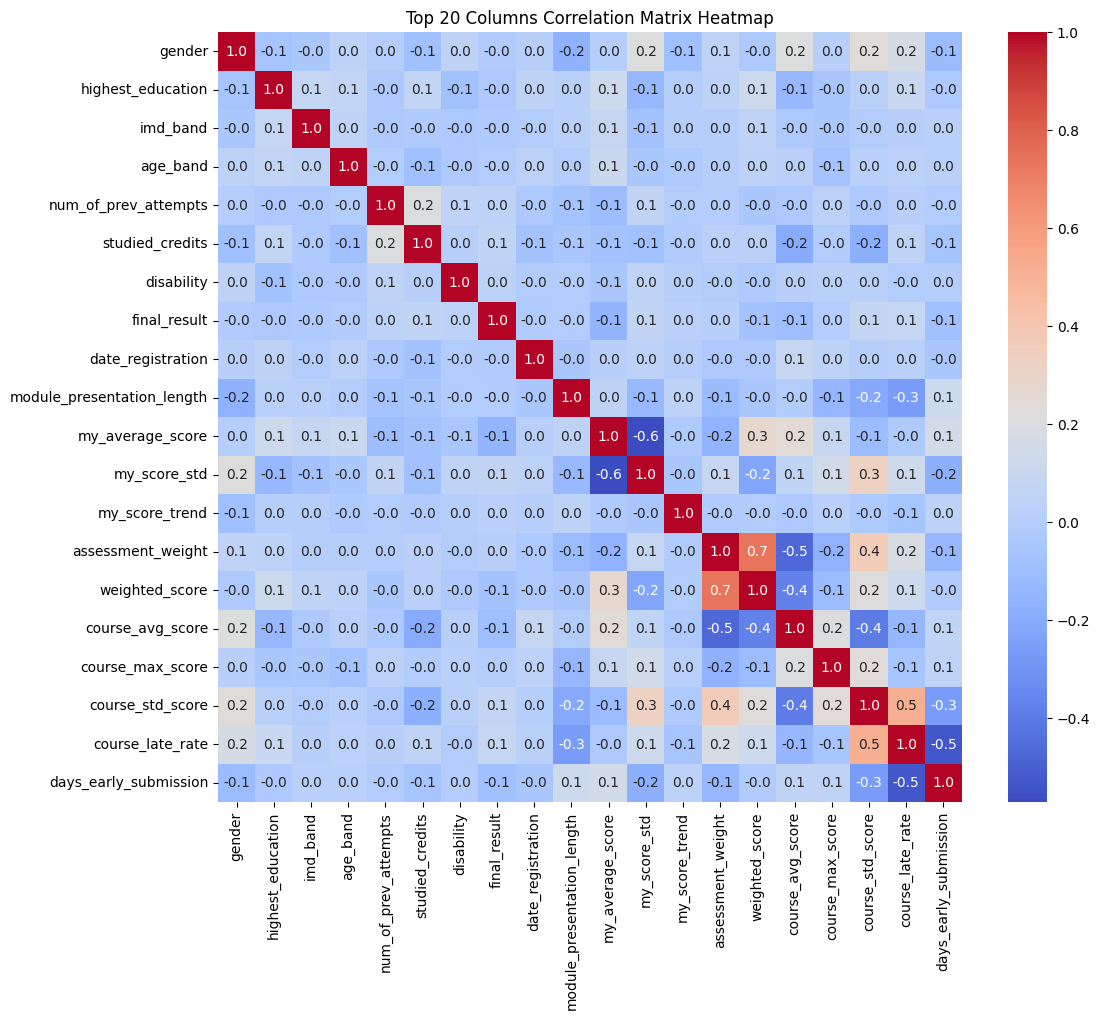

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 상관 행렬 계산
corr_matrix = df.corr(numeric_only=True, method='spearman')
corr_matrix

# 상위 20개 컬럼만 선택
top_20_columns = corr_matrix.columns[:20]
top_20_corr_matrix = corr_matrix.loc[top_20_columns, top_20_columns]

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(top_20_corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
plt.title('Top 20 Columns Correlation Matrix Heatmap')
plt.show()

### 여기부터는 위의 상관관계 확인후 분석 들어가야함

## (예시)**온라인 학습 활동 분석**
- sum_click(총 클릭 수)와 final_result(최종 성적) 간 상관관계 분석
- 학습 콘텐츠 유형(activity_type)별 평균 클릭 수(sum_click) 비교
- week_from, week_to를 활용한 주차별 학습 패턴 분석 (lineplot)

## (예시)**학생의 연령, 교육 수준, 장애 여부 등이 학습 성과와 관련 있는지 분석**
- age_band, highest_education, disability 등과 final_result 간 분포 비교 (countplot)
- num_of_prev_attempts(재수강 횟수)와 final_result 간 상관관계 분석
- date_unregistration 값이 있는 경우, 조기 이탈 학생과 학습 활동 비교

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168904 entries, 0 to 170856
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gender                      168904 non-null  int64  
 1   highest_education           168904 non-null  int64  
 2   imd_band                    168904 non-null  int64  
 3   age_band                    168904 non-null  int64  
 4   num_of_prev_attempts        168904 non-null  int64  
 5   studied_credits             168904 non-null  int64  
 6   disability                  168904 non-null  int64  
 7   final_result                168904 non-null  int64  
 8   date_registration           168904 non-null  float64
 9   module_presentation_length  168904 non-null  int64  
 10  my_average_score            168904 non-null  float64
 11  my_score_std                168904 non-null  float64
 12  my_score_trend              168904 non-null  int64  
 13  assessment_weight  

---

### randomforest

In [36]:
df.columns

Index(['gender', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result',
       'date_registration', 'module_presentation_length', 'my_average_score',
       'my_score_std', 'my_score_trend', 'assessment_weight', 'weighted_score',
       'course_avg_score', 'course_max_score', 'course_std_score',
       'course_late_rate', 'days_early_submission', 'my_late_rate',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J',
       'assessment_type_CMA', 'assessment_type_Exam', 'assessment_type_TMA'],
      dtype='object')

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


rf_clf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)


# 학습
X_train = df.drop(['final_result'],axis=1)
display(X_train)
y_train = df['final_result']

rf_clf.fit(X_train, y_train)

y_pred_train = rf_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

# y_pred_test = rf_clf.predict(X_test)
# acc_score_test = accuracy_score(y_test, y_pred_test)
# print('테스트 평가 점수:', acc_score_test)

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,module_presentation_length,my_average_score,...,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J,assessment_type_CMA,assessment_type_Exam,assessment_type_TMA
0,0,4699,9,2,0,240,0,-159.0,268,82.000000,...,False,False,False,False,True,False,False,False,False,True
1,1,4699,2,1,0,60,0,-53.0,268,66.400000,...,False,False,False,False,True,False,False,False,False,True
2,1,3630,5,1,0,60,0,-52.0,268,76.000000,...,False,False,False,False,True,False,False,False,False,True
3,1,3576,5,0,0,60,0,-176.0,268,54.400000,...,False,False,False,False,True,False,False,False,False,True
4,0,3630,8,1,0,60,0,-110.0,268,68.000000,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170852,1,3630,2,0,0,30,0,-2.0,269,73.888889,...,False,False,True,False,False,False,True,True,False,False
170853,1,3630,0,1,0,30,0,-10.0,269,79.857143,...,False,False,True,False,False,False,True,True,False,False
170854,0,3630,0,0,0,60,0,-10.0,269,87.250000,...,False,False,True,False,False,False,True,True,False,False
170855,1,3576,5,0,2,30,0,2.0,269,81.222222,...,False,False,True,False,False,False,True,True,False,False


학습 점수: 0.9298003599677923


<Axes: xlabel='None', ylabel='None'>

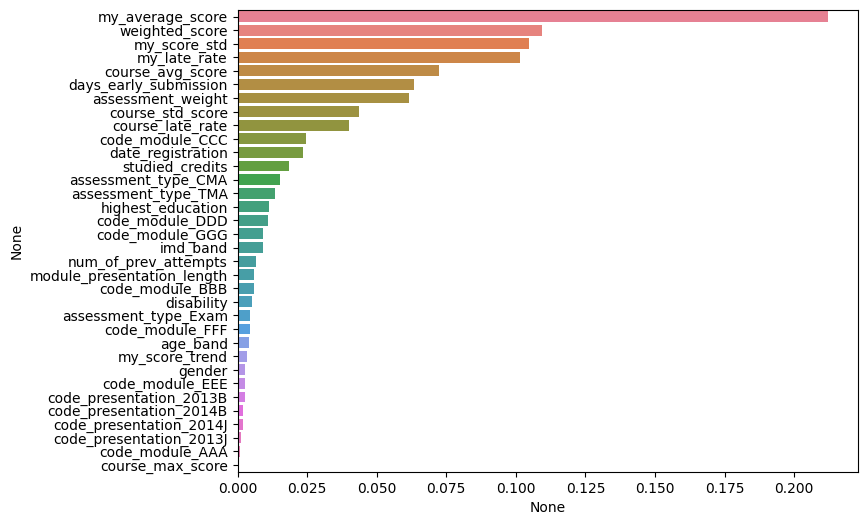

In [38]:
feat_imptc_ser = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feat_imptc_ser

# 특성 중요도 시각화
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_imptc_ser,
    y=feat_imptc_ser.index,
    hue=feat_imptc_ser.index
)

---

In [39]:
from sklearn.preprocessing import PolynomialFeatures

X_train2 = X_train[feat_imptc_ser[:20].keys()]

poly2 = PolynomialFeatures(include_bias=False, degree=2)     # degree 기본값 : 2
poly2.fit(X_train2)
X_train2_poly = poly2.transform(X_train2)

X_train2_poly

array([[8.20000000e+01, 5.48627242e-01, 3.08220700e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.18240000e+04],
       [6.64000000e+01, 4.92357781e-01, 4.33589668e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.18240000e+04],
       [7.60000000e+01, 5.06425147e-01, 6.89202438e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.18240000e+04],
       ...,
       [8.72500000e+01, 2.02926638e-01, 1.15974135e+01, ...,
        0.00000000e+00, 0.00000000e+00, 7.23610000e+04],
       [8.12222222e+01, 2.53658297e-01, 2.39258113e+01, ...,
        4.00000000e+00, 5.38000000e+02, 7.23610000e+04],
       [6.82222222e+01, 2.02926638e-01, 1.43246097e+01, ...,
        0.00000000e+00, 0.00000000e+00, 7.23610000e+04]],
      shape=(168904, 230))

In [40]:
# 학습
rf_clf2 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf_clf2.fit(X_train2_poly, y_train)

y_pred_train = rf_clf2.predict(X_train2_poly)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

feat_imptc_ser2 = pd.Series(rf_clf2.feature_importances_).sort_values(ascending=False)
# feat_imptc_ser2
print(X_train2_poly.shape)
print(y_train.shape)
X_train3_poly = X_train2_poly[:, feat_imptc_ser2[:20].keys()]
print(X_train3_poly.shape)

학습 점수: 0.930102306635722
(168904, 230)
(168904,)
(168904, 20)


In [41]:
original_columns = ['my_average_score', 'weighted_score', 'my_score_std', 'my_late_rate', 
       'course_avg_score', 'days_early_submission', 'assessment_weight',
       'course_std_score', 'course_late_rate', 'code_module_CCC',
       'date_registration', 'studied_credits', 'assessment_type_CMA',
       'assessment_type_TMA', 'highest_education', 'code_module_DDD',
       'code_module_GGG', 'imd_band', 'num_of_prev_attempts',
       'module_presentation_length']

columns = poly2.get_feature_names_out(original_columns)
columns = columns[feat_imptc_ser2[:20].keys()]

# 학습
rf_clf3 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf_clf3.fit(X_train3_poly, y_train)

y_pred_train = rf_clf3.predict(X_train3_poly)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

feat_imptc_ser3 = pd.Series(rf_clf3.feature_importances_).sort_values(ascending=False)
feat_imptc_ser3


X_train3_poly_df = pd.DataFrame(X_train3_poly, columns=columns)
X_train3_poly_df['final_result'] =  df['final_result']

학습 점수: 0.9306351536967745


In [42]:
X_train3_poly_df.to_csv('merged_poly_data_final.csv', index=False)
X_train3_poly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168904 entries, 0 to 168903
Data columns (total 21 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   my_average_score^2                           168904 non-null  float64
 1   my_average_score module_presentation_length  168904 non-null  float64
 2   my_average_score highest_education           168904 non-null  float64
 3   my_average_score                             168904 non-null  float64
 4   my_average_score course_avg_score            168904 non-null  float64
 5   my_score_std code_module_CCC                 168904 non-null  float64
 6   my_score_std course_late_rate                168904 non-null  float64
 7   my_average_score course_std_score            168904 non-null  float64
 8   my_average_score weighted_score              168904 non-null  float64
 9   course_avg_score                             168904 non-nul

,my_average_score^2,my_average_score module_presentation_length,my_average_score highest_education,my_average_score,my_average_score course_avg_score,my_score_std code_module_CCC,my_score_std course_late_rate,my_average_score course_std_score,my_average_score weighted_score,course_avg_score,...,my_average_score assessment_weight,my_average_score course_late_rate,my_average_score my_score_std,weighted_score module_presentation_length,weighted_score,weighted_score highest_education,my_late_rate^2,my_average_score days_early_submission,course_avg_score highest_education,final_result
0,6724.000000,21976.000000,385318.000000,82.000000,5693.394237,0.0,0.725670,1036.431602,44.987434,69.431637,...,0.576762,19.305947,252.740974,147.032101,0.548627,2577.999411,0.000000,82.000000,326259.262416,0.0
1,4408.960000,17795.200000,312013.600000,66.400000,4610.260699,0.0,1.020836,839.256809,32.692557,69.431637,...,0.467037,15.633109,287.903539,131.951885,0.492358,2313.589215,0.160000,-199.200000,326259.262416,0.0
2,5776.000000,20368.000000,275880.000000,76.000000,5276.804414,0.0,1.622647,960.595143,38.488311,69.431637,...,0.534560,17.893317,523.793853,135.721939,0.506425,1838.323282,0.000000,152.000000,252036.842428,0.0
3,2959.360000,14579.200000,194534.400000,54.400000,3777.081055,0.0,4.829644,687.583892,26.401631,69.431637,...,0.382632,12.807848,1115.929517,130.066858,0.485324,1735.518978,1.000000,-380.800000,248287.534028,0.0
4,4624.000000,18224.000000,246840.000000,68.000000,4721.351318,0.0,2.584466,859.479865,37.784943,69.431637,...,0.478290,16.009810,746.452946,148.917128,0.555661,2017.049157,0.040000,0.000000,252036.842428,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168899,5459.567901,19876.111111,268216.666667,73.888889,5843.426117,0.0,1.807261,1451.565063,11.245518,79.083962,...,0.187425,7.809807,1263.394371,40.940449,0.152195,552.467771,0.000000,147.777778,287074.783802,0.0
168900,6377.163265,21481.571429,289881.428571,79.857143,6315.419289,0.0,1.615037,1568.812853,20.256427,79.083962,...,0.202564,8.440631,1220.211369,68.234082,0.253658,920.779618,0.081633,0.000000,287074.783802,0.0
168901,7612.562500,23470.250000,316717.500000,87.250000,6900.075726,0.0,1.225808,1714.047316,17.705349,79.083962,...,0.221317,9.222032,1011.874328,54.587266,0.202927,736.623695,0.015625,1221.500000,287074.783802,0.0
168902,6597.049383,21848.777778,290450.666667,81.222222,6423.375175,0.0,2.528878,1595.630167,20.602691,79.083962,...,0.206027,8.584916,1943.307559,68.234082,0.253658,907.082070,0.111111,-81.222222,282804.249828,1.0


,my_average_score^2,my_average_score module_presentation_length,my_average_score highest_education,my_average_score,my_average_score course_avg_score,my_score_std code_module_CCC,my_score_std course_late_rate,my_average_score course_std_score,my_average_score weighted_score,course_avg_score,...,my_average_score assessment_weight,my_average_score course_late_rate,my_average_score my_score_std,weighted_score module_presentation_length,weighted_score,weighted_score highest_education,my_late_rate^2,my_average_score days_early_submission,course_avg_score highest_education,final_result
my_average_score^2,1.000000,0.927240,0.862267,1.000000,0.946317,0.008319,-0.306546,0.623831,0.506916,0.249946,...,0.265693,0.427677,-0.288891,0.273467,0.270332,0.274493,-0.127692,0.160171,0.272431,-0.024996
my_average_score module_presentation_length,0.927240,1.000000,0.803007,0.927240,0.888606,0.023886,-0.364460,0.543961,0.466655,0.229251,...,0.231740,0.320551,-0.285803,0.286191,0.238721,0.244921,-0.196555,0.192837,0.255838,-0.028423
my_average_score highest_education,0.862267,0.803007,1.000000,0.862267,0.801792,0.046472,-0.256115,0.550703,0.470937,0.169200,...,0.257041,0.401405,-0.254359,0.267926,0.265237,0.377853,-0.101014,0.125925,0.539954,-0.014558
my_average_score,1.000000,0.927240,0.862267,1.000000,0.946317,0.008319,-0.306546,0.623831,0.506916,0.249946,...,0.265693,0.427677,-0.288891,0.273467,0.270332,0.274493,-0.127692,0.160171,0.272431,-0.024996
my_average_score course_avg_score,0.946317,0.888606,0.801792,0.946317,1.000000,-0.059753,-0.294428,0.473075,0.348095,0.500485,...,0.105962,0.352660,-0.226046,0.110784,0.104311,0.109036,-0.120475,0.181584,0.409610,-0.050945
my_score_std code_module_CCC,0.008319,0.023886,0.046472,0.008319,-0.059753,1.000000,0.352602,0.316368,0.088009,-0.265500,...,0.084561,0.433836,-0.012440,0.095655,0.084943,0.110262,0.282431,-0.248503,-0.096289,0.090636
my_score_std course_late_rate,-0.306546,-0.364460,-0.256115,-0.306546,-0.294428,0.352602,1.000000,0.200988,-0.174622,0.032218,...,-0.027919,0.572209,0.648865,-0.107434,-0.077467,-0.084150,0.681968,-0.497371,-0.013768,0.041962
my_average_score course_std_score,0.623831,0.543961,0.550703,0.623831,0.473075,0.316368,0.200988,1.000000,0.480199,-0.071392,...,0.408495,0.591714,0.120765,0.365415,0.376628,0.366561,0.118958,-0.094337,0.008417,0.029115
my_average_score weighted_score,0.506916,0.466655,0.470937,0.506916,0.348095,0.088009,-0.174622,0.480199,1.000000,-0.252015,...,0.867209,0.289311,-0.214827,0.944648,0.951453,0.924252,-0.083733,0.053982,-0.073819,0.023378
course_avg_score,0.249946,0.229251,0.169200,0.249946,0.500485,-0.265500,0.032218,-0.071392,-0.252015,1.000000,...,-0.339546,0.053938,0.175935,-0.372009,-0.369646,-0.375632,0.056908,0.064579,0.602900,-0.099893


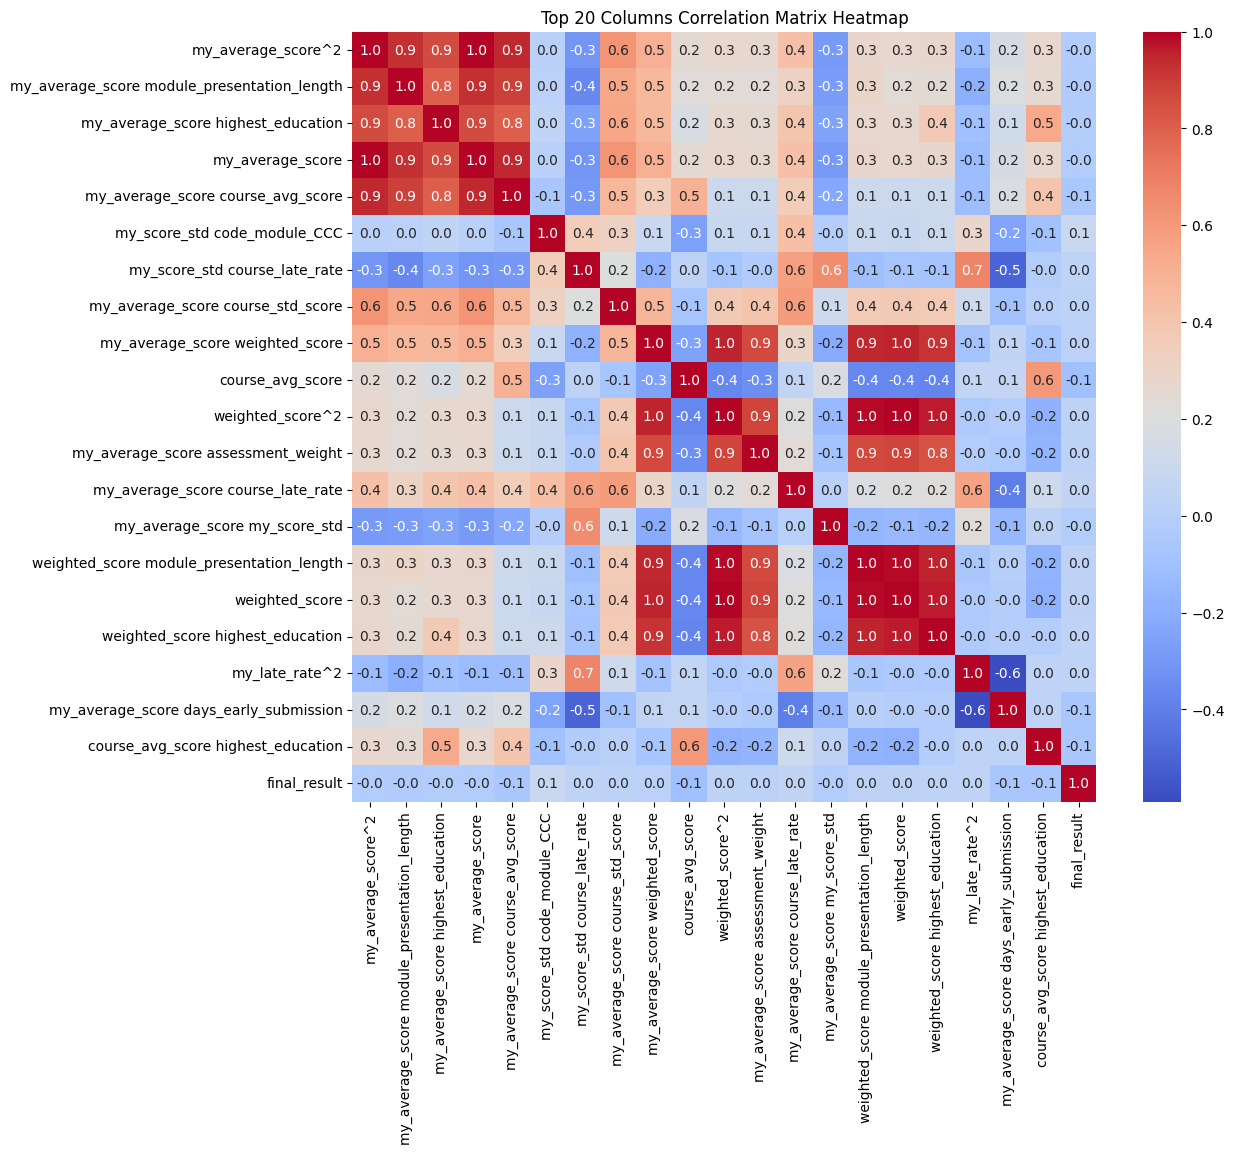

In [43]:
# 상관 행렬 계산
display(X_train3_poly_df)
corr_matrix = X_train3_poly_df.corr(numeric_only=True, method='spearman')
corr_matrix

display(corr_matrix)

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
plt.title('Top 20 Columns Correlation Matrix Heatmap')
plt.show()